# Calculate RMSE

In [1]:
import os
import sys
import yaml
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu

In [3]:
config_name = os.path.realpath('verif_config_6h.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

In [4]:
model_name = 'wxformer'
lead_range = conf[model_name]['lead_range']
verif_lead_range = conf[model_name]['verif_lead_range']

leads_exist = list(np.arange(lead_range[0], lead_range[-1]+lead_range[0], lead_range[0]))
leads_verif = list(np.arange(verif_lead_range[0], verif_lead_range[-1]+verif_lead_range[0], verif_lead_range[0]))
ind_lead = vu.lead_to_index(leads_exist, leads_verif)

print('Verifying lead times: {}'.format(leads_verif))
print('Verifying lead indices: {}'.format(ind_lead))

Verifying lead times: [6, 12, 18, 24]
Verifying lead indices: [0, 1, 2, 3]


In [5]:
verif_ind_start = 0; verif_ind_end = 366*2
path_verif = conf[model_name]['save_loc_verif']+'combined_rmse_{:04d}_{:04d}_{:03d}h_{:03d}h_{}.nc'.format(
                                                                                            verif_ind_start, 
                                                                                            verif_ind_end,
                                                                                            verif_lead_range[0],
                                                                                            verif_lead_range[-1],
                                                                                            model_name)

## Verification setup

The following inputs are needed:

(1) range of indices

(2) required lead times to verify

(3) save location

In [6]:
# ---------------------------------------------------------------------------------------- #
# ERA5 verif target
filename_ERA5 = sorted(glob(conf['ERA5_ours']['save_loc']))

# pick years
year_range = conf['ERA5_ours']['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_ERA5 = [fn for fn in filename_ERA5 if any(year in fn for year in years_pick)]

# merge yearly ERA5 as one
ds_ERA5 = [vu.get_forward_data(fn) for fn in filename_ERA5]
ds_ERA5_merge = xr.concat(ds_ERA5, dim='time')
    
# Select the specified variables and their levels
variables_levels = conf['ERA5_ours']['verif_variables']

# subset merged ERA5 and unify coord names
ds_ERA5_merge = vu.ds_subset_everything(ds_ERA5_merge, variables_levels)
ds_ERA5_merge = ds_ERA5_merge.rename({'latitude':'lat','longitude':'lon'})

# ---------------------------------------------------------------------------------------- #
# forecast
filename_OURS = sorted(glob(conf[model_name]['save_loc_gather']+'*.nc'))

# pick years
year_range = conf[model_name]['year_range']
years_pick = np.arange(year_range[0], year_range[1]+1, 1).astype(str)
filename_OURS = [fn for fn in filename_OURS if any(year in fn for year in years_pick)]
# filename_OURS = [fn for fn in filename_OURS if '00Z' in fn]

L_max = len(filename_OURS)
assert verif_ind_end <= L_max, 'verified indices (days) exceeds the max index available'

filename_OURS = filename_OURS[verif_ind_start:verif_ind_end]

# latitude weighting
lat = xr.open_dataset(filename_OURS[0])["lat"]
w_lat = np.cos(np.deg2rad(lat))
w_lat = w_lat / w_lat.mean()

In [7]:
# some of the forecast files have lat/lon as masked arrays
# this may result-in a mismatch between the weatherbench clim (lat/lon arrays) and the fcst (masked arrays)
# it only happens to some CREDIT rollouts but will be applied to IFS as well
OURS_dataset = xr.open_dataset(conf['geo']['geo_file_nc'])
x_OURS = np.array(OURS_dataset['longitude'])
y_OURS = np.array(OURS_dataset['latitude'])

In [8]:
# ---------------------------------------------------------------------------------------- #
# RMSE compute
verif_results = []

for fn_ours in filename_OURS:
    ds_ours = xr.open_dataset(fn_ours)
    ds_ours = vu.ds_subset_everything(ds_ours, variables_levels)
    ds_ours = ds_ours.isel(time=ind_lead)

    # ============================== #
    # resolve the masked array issue
    ds_ours['lon'] = x_OURS
    ds_ours['lat'] = y_OURS
    # ============================== #
    ds_ours = ds_ours.compute()
    
    ds_target = ds_ERA5_merge.sel(time=ds_ours['time']).compute()

    # ds_ours = ds_ours.isel(time=slice(0, 3))
    # ds_target = ds_target.isel(time=slice(1, 4))
    # ds_target['time'] = ds_ours['time']
    
    # RMSE with latitude-based cosine weighting (check w_lat)
    RMSE = np.sqrt(
        (w_lat * (ds_ours - ds_target)**2).mean(['lat', 'lon'])
    )
    
    verif_results.append(RMSE.drop_vars('time'))

    #print('Completedd: {}'.format(fn_ours))
    
# Combine verif results
ds_verif = xr.concat(verif_results, dim='days')

# Save the combined dataset
print('Save to {}'.format(path_verif))
#ds_verif.to_netcdf(path_verif)

Save to /glade/derecho/scratch/ksha/CREDIT/VERIF/verif_6h/wxformer_6h/combined_rmse_0000_0732_006h_024h_wxformer.nc


## Old verification results (single-step, residual norm)

In [12]:
for varname in ['SP','t2m','V500','U500','T500','Z500','Q500']:
    rmse = np.array(ds_verif[varname]).mean(axis=0)
    print('{},{},{},{}'.format(rmse[0], rmse[1], rmse[2], rmse[3]))

37.04956316131425,177.55944391141563,171.02808077733297,293.62573955817004
0.6293111688437956,3.0691526088181513,5.618295709017567,6.188175485314244
0.8889885090524957,1.4750378039100893,1.7217061460416105,2.163037749282198
0.8644163228677657,1.4669997862821968,1.7104699046371459,2.22450833328573
0.2704141461297696,0.47433445062217167,0.7295187676609377,0.9374433549282644
26.532835339547876,133.28278625103994,103.85805697748869,195.73397015789453
0.0001493254010269469,0.0002664903743579382,0.00035203948700454466,0.000469123082471149


## Old verification results (single-step, without residual norm)

In [10]:
for varname in ['SP','t2m','V500','U500','T500','Z500','Q500']:
    print(np.array(ds_verif[varname]).mean(axis=0))

[128.72873076 266.55757598 285.49885164 432.84606742]
[0.79157407 3.1049515  5.56724467 6.06384579]
[0.80125001 1.46625007 1.75198062 2.20361116]
[0.83180918 1.48557501 1.76013111 2.29564558]
[0.33188993 0.51468507 0.74387381 0.94216249]
[ 43.05258478 165.81410738 129.6984895  245.21335695]
[0.00014156 0.00026589 0.00035387 0.00046905]


In [10]:
np.array(ds_verif['Z500']).mean(axis=0)

array([ 43.32829167, 167.28990652, 132.00087903, 248.12248364])

In [11]:
np.array(ds_verif['Q500']).mean(axis=0)

array([0.00014179, 0.00026584, 0.000353  , 0.00046831])

In [12]:
np.array(ds_verif['t2m']).mean(axis=0)

array([0.79269024, 3.10166982, 5.56428144, 6.06117731])

In [13]:
# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

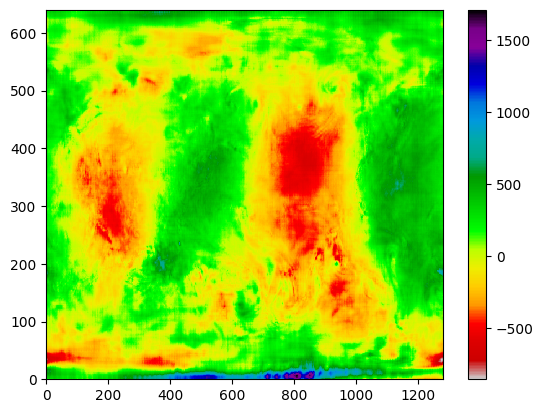

In [45]:
plt.pcolormesh(np.array(ds_ours['Z500'])[2, ...]-np.array(ds_target['Z500'])[2, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

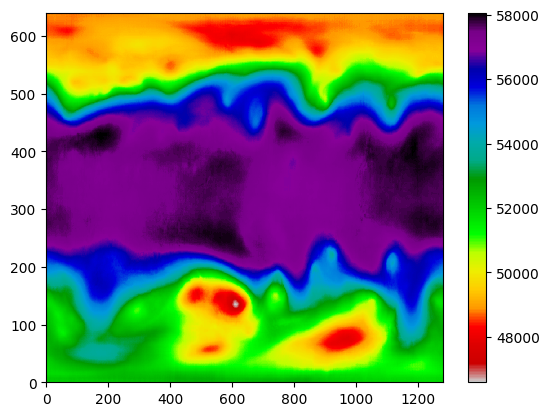

In [22]:
plt.pcolormesh(np.array(ds_ours['Z500'])[1, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

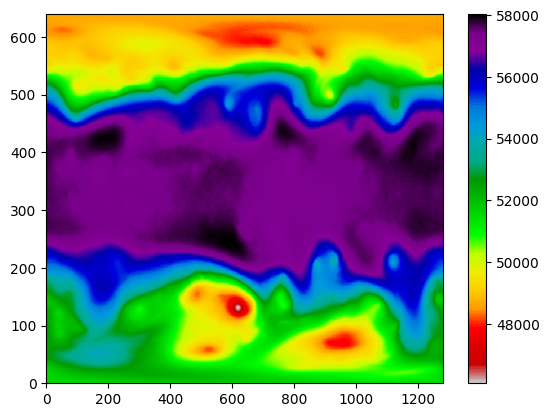

In [23]:
plt.pcolormesh(np.array(ds_target['Z500'])[1, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

In [ ]:
np.array(ds_target['Z500'])[0, ...]